<a href="https://www.kaggle.com/code/syerramilli/planttraits-efficientnet-image-tabular?scriptVersionId=179210373" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Introduction

In this notebook we will train a baseline multi-output regression model in Keras on the images and the ancillary data (satellite data, soil data, climate data etc.) to predict the 6 plant properties.

**CHANGELOG**:

v1 -> v2: 
1. Replaced EfficientNet V1 with V2
2. Removed the rescaling layer prior to EfficientNet. This layer was erroneously included.

v2 -> v3:
Increased the number of training epochs (10 -> 15)

v3 -> v4:
1. Further Increased the number of training epochs (15 -> 25)
2. Set the number of warmup steps as a percentage (20%) of the total number of optimization steps

v4 -> v5:
Dropping highly correlated features in the tabular data through hierarchical clustering

v5 -> v10:
1. Training ensembles of models
2. Reducing the number of training epochs for each model in the ensemble (25 -> 15)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

import tensorflow as tf
import keras
from keras.applications.efficientnet_v2 import EfficientNetV2B0, preprocess_input

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold

from pathlib import Path

plt.style.use('ggplot')
plt.rcParams.update(**{'figure.dpi':150})

2024-05-22 23:59:41.562409: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-22 23:59:41.562549: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-22 23:59:41.696746: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
## global configuration
CFG = {
    'N_SPLITS': 5,
    'BATCH_SIZE': 128,
    'NUM_EPOCHS': 15,
    'MAX_LR': 5e-4,
    'WARMUP_PCT': 0.2,
    'n_tabular_layers': 2,
    'img_backbone_final_dim': 128,
    'tabular_hsizes': [256, 128],
    'n_ff_layers': 2,
    'ff_hsizes': [128, 64]
}

## Loading the data

In [3]:
path = Path('/kaggle/input/planttraits2024/')
imgs_train = path / 'train_images'
imgs_test = path / 'test_images'

train = pd.read_csv(path / 'train.csv')
train['img_path'] = train['id'].apply(lambda x: imgs_train / f'{x}.jpeg')

test = pd.read_csv(path / 'test.csv')
test['img_path'] = test['id'].apply(lambda x: imgs_test / f'{x}.jpeg')

In [4]:
targets = ['X4', 'X11', 'X18', 'X50', 'X26', 'X3112']
target_cols = [f'{col}_mean' for col in targets]
target_cols

['X4_mean', 'X11_mean', 'X18_mean', 'X50_mean', 'X26_mean', 'X3112_mean']

In [5]:
# remove sd columns
sd_cols = [f'{col}_sd' for col in targets]
train = train.drop(columns = sd_cols)

## Preprocessing

In [6]:
img_paths = train['img_path'].astype(str).values
tabular = train.drop(columns = ['id', 'img_path'] + target_cols)
Y = train[target_cols]

In [7]:
# remove bad observations
upper_quantiles = Y.quantile(0.98)
retained_flag = (Y < upper_quantiles).all(axis= 1) & (Y > 0).all(axis=1)
img_paths = img_paths[retained_flag]
tabular = tabular[retained_flag]
Y = Y[retained_flag]

print(f'Number of observations removed: {retained_flag.shape[0] - retained_flag.sum()}')

Number of observations removed: 5691


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

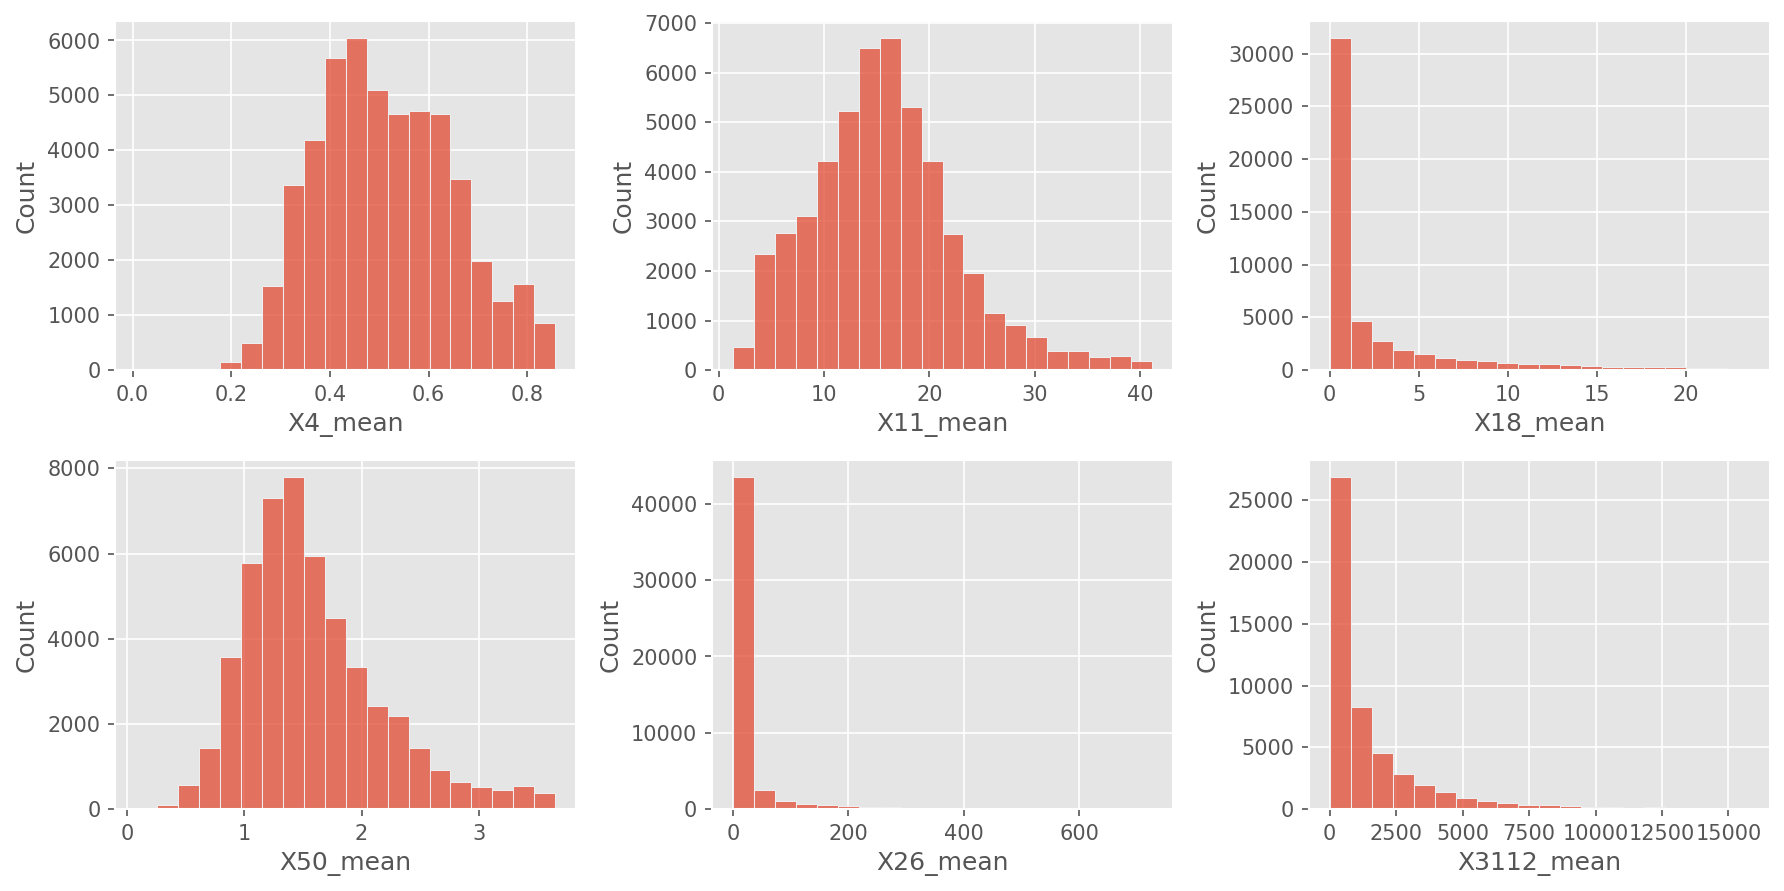

In [8]:
# histograms after filtering out bad observations
n_rows = 2
n_cols = 3
fig, axs = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3 * n_rows))
for i, column in enumerate(Y.columns):
    row_idx, col_idx = divmod(i, n_cols)
    _ = sns.histplot(data=Y, x=column, ax=axs[row_idx, col_idx], bins=20)

fig.tight_layout()


In [9]:
# standardize response
output_sc = StandardScaler()
Y_sc = output_sc.fit_transform(Y)
_ = joblib.dump(output_sc, 'output_scaler.pkl')

## Tabular preprocessing

We now compute the Spearman rank correlations between pairs of the features, and drop ones which are highly correlated with each other. Since there are many columns, we will perform hierarchical clustering to cluster the features.

Hierarchical clustering arranges the data (in our case, features) using a dissimilarity (or distance) matrix. In our case, we compute the dissimilarity between two features $x_i$ and $x_j$  as
$$
    \large
    d(x_i,x_j) = 1 - |r(x_i, x_j)|,
$$
where $r(x_i, x_j)$ is the Spearman rank correlation between $x_1$ and $x_2$. The Spearman rank measures the degrees of monotonic dependence between two features. Values closer to +1 or -1 indicate a monotonically increasing or decreasing relationships respectively. So, the dissimilarity between two features will be close to 0 if they are nearly monotonic fuctions of each other. 

In [10]:
# construct correlation matrix
corr_matrix = tabular.corr(method='spearman')

# hierarchical cluster based on the correlations
dissimilarity = 1 - abs(corr_matrix.values)

After computing the dissimilaity matrix, we then perform hierarchical clustering on the features. We can then visualize the hierarchy of relationships using a dendrogram plot, which displays a tree-like structure, with branches that represent the merging of similar features at different levels of dissimilarity. The leaves of the dendograms are the features.

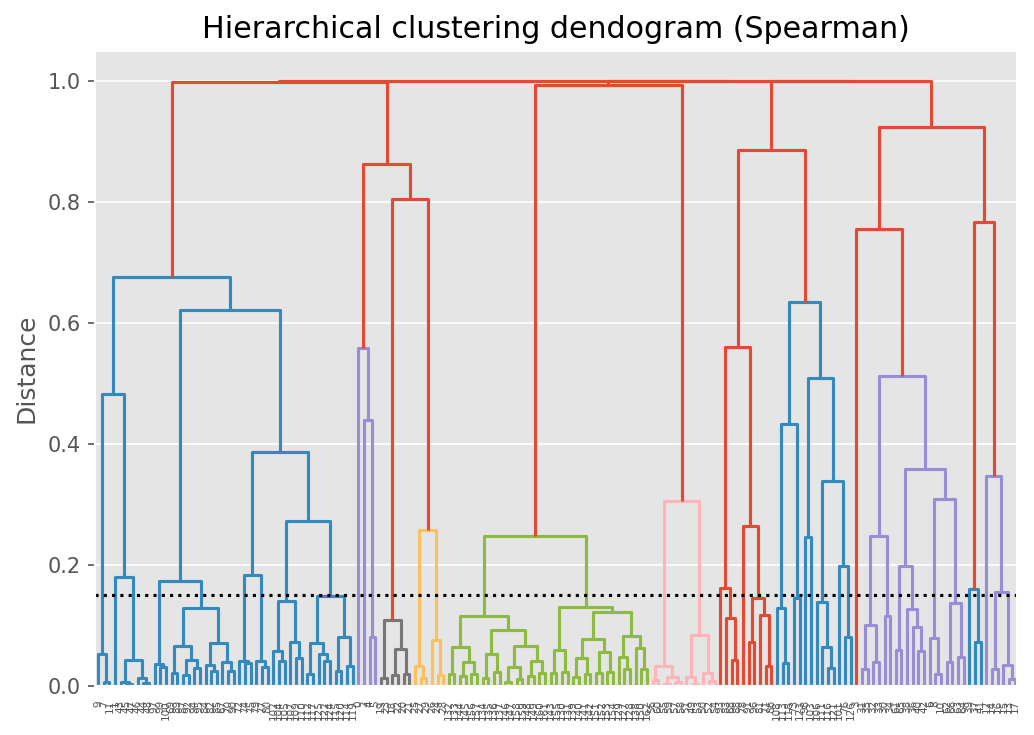

In [11]:
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform

linkage_matrix = hierarchy.linkage(squareform(dissimilarity), method='complete')

# plot the dendogram
fig,ax = plt.subplots(1,1,figsize=(7,5))
dendogram = hierarchy.dendrogram(
    linkage_matrix, ax=ax, 
#     labels=corr_matrix.columns.tolist(),
)
# _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
_ = ax.set_ylabel('Distance')
_ = ax.set_title('Hierarchical clustering dendogram (Spearman)')
_ = ax.axhline(0.15, 0, 1, linestyle='dotted', color='k')
_ = ax.grid(False, axis='x')
fig.tight_layout()

We will now generate the cluster labels for each feature. The number of clusters will depend on the distance we use as threshold. For smaller distance thresholds, more clusters will be formed. Here, we use a distance threshold of 0.15. 

In [12]:
# get the cluster labels
threshold = 0.15
cluster_labels = hierarchy.fcluster(linkage_matrix, threshold, criterion='distance')
n_clusters = np.unique(cluster_labels).shape[0]
print(f'Number of clusters: {n_clusters}\n')

Number of clusters: 42



In [13]:
import json
cluster_features = {}

# show features within each cluster
for label in range(1, n_clusters + 1):
    #print(f'Cluster {label}')
    
    leaves_in_cluster = cluster_labels == label
    cluster_features[label] = corr_matrix.columns[leaves_in_cluster].tolist()
    #print(cluster_features[label])
    #print()
    
with open('feature_clusters.json', 'w') as f:
    json.dump(cluster_features, f)

Finally, we will select only one feature from each cluster. 

In [14]:
final_features = []
for cols_in_cluster in cluster_features.values():
    final_features.append(cols_in_cluster[0])
    
tabular = tabular[final_features]

For the select features, we will apply min-max normalization. 

In [15]:
# normalize tabular inputs
tabular_input_sc = MinMaxScaler()
tabular_sc = tabular_input_sc.fit_transform(tabular).astype(np.float32)
_ = joblib.dump(tabular_input_sc, 'tabuler_input_scaler.pkl')

## Image preprocessing functions

In [16]:
def process_image_from_file(file_path:str) -> tf.Tensor:
    # load the image
    img = tf.io.read_file(file_path)
    # decode the jpeg file 
    img = tf.image.decode_jpeg(img, channels=3)
    # resize the image to 224 x 224 
    img = tf.image.resize(img, [224, 224])
    # preprocessing for efficient net 
    # per documentation, does nothing; including it
    # here for consistency
    img = preprocess_input(img)
    return img

# Define your dataset processing function
def process_path(file_path, tabular, targets):
    return (process_image_from_file(file_path), tabular), targets

def process_paths_wo_targets(file_path, tabular):
    return ((process_image_from_file(file_path), tabular),)

## Model architecture

In [17]:
def create_model(backbone, num_steps_per_epoch):

    ############################## 
    # IMG Processing
    ############################## 
    img_input = keras.layers.Input(shape = (224, 224, 3), name="img_input")

    img_backbone = keras.Sequential([
        # augmentation layers
        keras.Sequential([
            keras.layers.RandomRotation(factor=0.1, interpolation='nearest'),
            keras.layers.RandomTranslation(
                height_factor=0.1, width_factor=0.1, interpolation='nearest'
            ),
            keras.layers.RandomZoom(height_factor=(0.05, 0.15)),
            keras.layers.RandomFlip(mode="horizontal_and_vertical")
        ], name='augmentation'),
        #### Efficientnet backbone ####
        backbone,
        ###############################
        keras.layers.GlobalAveragePooling2D(),
        keras.layers.Dense(CFG['img_backbone_final_dim'])
    ], name='img_backbone')

    # fix efficientnet weights 
    img_backbone.get_layer('efficientnetv2-b0').trainable = False

    img_output = img_backbone(img_input)

    ############################## 
    # Tabular Processing
    ##############################
    tabular_input = keras.layers.Input(shape = (tabular_sc.shape[1],) , name="tabular_input")

    backbone_blocks = []
    for i in range(CFG['n_tabular_layers']):
        backbone_blocks.extend([
            keras.layers.Dense(CFG['tabular_hsizes'][i], name=f'tabular_block_{i}_dense'),
            keras.layers.BatchNormalization(),
            keras.layers.ReLU(),
            keras.layers.Dropout(0.1)
        ])

    tabular_backbone = keras.Sequential(backbone_blocks, name='tabular_backbone')
    tabular_output = tabular_backbone(tabular_input)

    ##############################
    # Concat and outputs
    ##############################
    output = keras.layers.Concatenate()([img_output, tabular_output])
    for i in range(CFG['n_ff_layers']):
        output = keras.layers.Dense(CFG['tabular_hsizes'][i], name=f'ff_block_{i}_dense')(output)
        output = keras.layers.BatchNormalization()(output)
        output = keras.layers.ReLU()(output)
        output = keras.layers.Dropout(0.1)(output)


    output = keras.layers.Dense(6, name='output')(output)

    model = keras.Model(inputs=[img_input, tabular_input], outputs=output)


    num_steps_per_epoch = num_steps_per_epoch
    total_steps = CFG['NUM_EPOCHS'] * num_steps_per_epoch
    warmup_steps = np.ceil(CFG['WARMUP_PCT'] * total_steps).astype(int)


    lr_scheduler = keras.optimizers.schedules.CosineDecay(
        initial_learning_rate = 1e-5,
        decay_steps = total_steps - warmup_steps,
        warmup_target= CFG['MAX_LR'],
        warmup_steps = warmup_steps
    )

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr_scheduler),
        loss= keras.losses.MeanSquaredError(),
        metrics=[keras.metrics.R2Score()]
    )
    
    return model

## Training the ensemble models

In [18]:
keras.backend.clear_session()

# download the weights
efficientnet_backbone = EfficientNetV2B0(include_top=False, weights='imagenet')
# fix efficientnet weights
efficientnet_backbone.trainable = False


models_ensemble = [None] * CFG['N_SPLITS']
histories = [None] * CFG['N_SPLITS']
CV_splitter = KFold(n_splits=CFG['N_SPLITS'], random_state=1, shuffle=True)
Y_cv_pred = Y_sc.astype(np.float32).copy()

for i, (idxs_train, idxs_val) in enumerate(CV_splitter.split(tabular_sc)):
    print(f'******************** Processing split {i + 1} ********************')
    
    # training split
    paths_train = img_paths[idxs_train,...]
    tabular_train = tabular_sc[idxs_train,...]
    Y_train = Y_sc[idxs_train,...]
    
    # validation split
    paths_val = img_paths[idxs_val,...]
    tabular_val = tabular_sc[idxs_val,...]
    Y_val = Y_sc[idxs_val,...]
    
    # datasets with targets
    train_ds = tf.data.Dataset.from_tensor_slices((paths_train, tabular_train.astype(np.float32), Y_train.astype(np.float32)))
    val_ds = tf.data.Dataset.from_tensor_slices((paths_val, tabular_val.astype(np.float32), Y_val.astype(np.float32)))
    
    train_ds = train_ds.map(process_path).batch(CFG['BATCH_SIZE'])
    val_ds = val_ds.map(process_path).batch(CFG['BATCH_SIZE'])
    
    # train model
    models_ensemble[i] = create_model(efficientnet_backbone, len(train_ds))
    histories[i] = models_ensemble[i].fit(train_ds, validation_data=val_ds, epochs=CFG['NUM_EPOCHS'])
    
    # save weights
    models_ensemble[i].save_weights(f"model_split{i+1}.weights.h5")
    
    # compute out-of-fold predictions
    val_ds = tf.data.Dataset.from_tensor_slices((paths_val, tabular_val.astype(np.float32)))
    val_ds = val_ds.map(process_paths_wo_targets).batch(256)
    
    Y_cv_pred[idxs_val, :] = models_ensemble[i].predict(val_ds)

24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
******************** Processing split 1 ********************
Epoch 1/15


2024-05-23 00:00:23.394118: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_4_1/img_backbone_1/efficientnetv2-b0_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


312/312 ━━━━━━━━━━━━━━━━━━━━ 118s 313ms/step - loss: 1.9642 - r2_score: -0.9398 - val_loss: 0.9106 - val_r2_score: 0.0836
Epoch 2/15
312/312 ━━━━━━━━━━━━━━━━━━━━ 49s 156ms/step - loss: 1.0126 - r2_score: 8.9406e-04 - val_loss: 0.7765 - val_r2_score: 0.2188
Epoch 3/15
312/312 ━━━━━━━━━━━━━━━━━━━━ 49s 156ms/step - loss: 0.8704 - r2_score: 0.1413 - val_loss: 0.7502 - val_r2_score: 0.2453
Epoch 4/15
312/312 ━━━━━━━━━━━━━━━━━━━━ 83s 160ms/step - loss: 0.8156 - r2_score: 0.1954 - val_loss: 0.7339 - val_r2_score: 0.2617
Epoch 5/15
312/312 ━━━━━━━━━━━━━━━━━━━━ 49s 156ms/step - loss: 0.7897 - r2_score: 0.2209 - val_loss: 0.7270 - val_r2_score: 0.2687
Epoch 6/15
312/312 ━━━━━━━━━━━━━━━━━━━━ 82s 156ms/step - loss: 0.7689 - r2_score: 0.2415 - val_loss: 0.7183 - val_r2_score: 0.2774
Epoch 7/15
312/312 ━━━━━━━━━━━━━━━━━━━━ 49s 155ms/step - loss: 0.7585 - r2_score: 0.2517 - val_loss: 0.7115 - val_r2_score: 0.2843
Epoch 8/15
312/312 ━━━━━━━━━━━━━━━━━━━━ 82s 156ms/step - loss: 0.7457 - r2_score: 0.2644

2024-05-23 00:16:52.025325: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_9_1/img_backbone_1/efficientnetv2-b0_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


312/312 ━━━━━━━━━━━━━━━━━━━━ 66s 164ms/step - loss: 1.7192 - r2_score: -0.7082 - val_loss: 0.8832 - val_r2_score: 0.1101
Epoch 2/15
312/312 ━━━━━━━━━━━━━━━━━━━━ 49s 156ms/step - loss: 0.9963 - r2_score: 0.0103 - val_loss: 0.7753 - val_r2_score: 0.2181
Epoch 3/15
312/312 ━━━━━━━━━━━━━━━━━━━━ 82s 157ms/step - loss: 0.8501 - r2_score: 0.1558 - val_loss: 0.7481 - val_r2_score: 0.2455
Epoch 4/15
312/312 ━━━━━━━━━━━━━━━━━━━━ 49s 155ms/step - loss: 0.7989 - r2_score: 0.2066 - val_loss: 0.7296 - val_r2_score: 0.2642
Epoch 5/15
312/312 ━━━━━━━━━━━━━━━━━━━━ 82s 157ms/step - loss: 0.7760 - r2_score: 0.2293 - val_loss: 0.7285 - val_r2_score: 0.2652
Epoch 6/15
312/312 ━━━━━━━━━━━━━━━━━━━━ 49s 155ms/step - loss: 0.7579 - r2_score: 0.2473 - val_loss: 0.7199 - val_r2_score: 0.2739
Epoch 7/15
312/312 ━━━━━━━━━━━━━━━━━━━━ 49s 157ms/step - loss: 0.7467 - r2_score: 0.2584 - val_loss: 0.7187 - val_r2_score: 0.2751
Epoch 8/15
312/312 ━━━━━━━━━━━━━━━━━━━━ 49s 155ms/step - loss: 0.7394 - r2_score: 0.2657 - va

2024-05-23 00:32:54.014004: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_14_1/img_backbone_1/efficientnetv2-b0_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


312/312 ━━━━━━━━━━━━━━━━━━━━ 65s 163ms/step - loss: 1.6134 - r2_score: -0.6115 - val_loss: 0.9244 - val_r2_score: 0.1013
Epoch 2/15
312/312 ━━━━━━━━━━━━━━━━━━━━ 48s 155ms/step - loss: 1.0015 - r2_score: -5.7930e-05 - val_loss: 0.8119 - val_r2_score: 0.2111
Epoch 3/15
312/312 ━━━━━━━━━━━━━━━━━━━━ 49s 156ms/step - loss: 0.8526 - r2_score: 0.1488 - val_loss: 0.7788 - val_r2_score: 0.2433
Epoch 4/15
312/312 ━━━━━━━━━━━━━━━━━━━━ 49s 156ms/step - loss: 0.7994 - r2_score: 0.2019 - val_loss: 0.7658 - val_r2_score: 0.2561
Epoch 5/15
312/312 ━━━━━━━━━━━━━━━━━━━━ 82s 155ms/step - loss: 0.7667 - r2_score: 0.2346 - val_loss: 0.7555 - val_r2_score: 0.2660
Epoch 6/15
312/312 ━━━━━━━━━━━━━━━━━━━━ 49s 156ms/step - loss: 0.7523 - r2_score: 0.2490 - val_loss: 0.7533 - val_r2_score: 0.2683
Epoch 7/15
312/312 ━━━━━━━━━━━━━━━━━━━━ 82s 155ms/step - loss: 0.7411 - r2_score: 0.2601 - val_loss: 0.7467 - val_r2_score: 0.2747
Epoch 8/15
312/312 ━━━━━━━━━━━━━━━━━━━━ 49s 156ms/step - loss: 0.7299 - r2_score: 0.2714

2024-05-23 00:48:54.561470: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_19_1/img_backbone_1/efficientnetv2-b0_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


312/312 ━━━━━━━━━━━━━━━━━━━━ 68s 171ms/step - loss: 1.7150 - r2_score: -0.7039 - val_loss: 0.8941 - val_r2_score: 0.1031
Epoch 2/15
312/312 ━━━━━━━━━━━━━━━━━━━━ 49s 156ms/step - loss: 1.0096 - r2_score: -0.0015 - val_loss: 0.7656 - val_r2_score: 0.2316
Epoch 3/15
312/312 ━━━━━━━━━━━━━━━━━━━━ 82s 155ms/step - loss: 0.8662 - r2_score: 0.1410 - val_loss: 0.7421 - val_r2_score: 0.2552
Epoch 4/15
312/312 ━━━━━━━━━━━━━━━━━━━━ 49s 157ms/step - loss: 0.8082 - r2_score: 0.1985 - val_loss: 0.7230 - val_r2_score: 0.2743
Epoch 5/15
312/312 ━━━━━━━━━━━━━━━━━━━━ 82s 159ms/step - loss: 0.7800 - r2_score: 0.2267 - val_loss: 0.7148 - val_r2_score: 0.2825
Epoch 6/15
312/312 ━━━━━━━━━━━━━━━━━━━━ 48s 155ms/step - loss: 0.7639 - r2_score: 0.2425 - val_loss: 0.7101 - val_r2_score: 0.2872
Epoch 7/15
312/312 ━━━━━━━━━━━━━━━━━━━━ 49s 156ms/step - loss: 0.7467 - r2_score: 0.2598 - val_loss: 0.7063 - val_r2_score: 0.2910
Epoch 8/15
312/312 ━━━━━━━━━━━━━━━━━━━━ 49s 155ms/step - loss: 0.7419 - r2_score: 0.2645 - v

2024-05-23 01:03:21.929704: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_24_1/img_backbone_1/efficientnetv2-b0_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


312/312 ━━━━━━━━━━━━━━━━━━━━ 66s 166ms/step - loss: 1.7563 - r2_score: -0.7378 - val_loss: 0.8809 - val_r2_score: 0.1080
Epoch 2/15
312/312 ━━━━━━━━━━━━━━━━━━━━ 79s 157ms/step - loss: 1.0227 - r2_score: -0.0091 - val_loss: 0.7825 - val_r2_score: 0.2073
Epoch 3/15
312/312 ━━━━━━━━━━━━━━━━━━━━ 49s 156ms/step - loss: 0.8630 - r2_score: 0.1489 - val_loss: 0.7479 - val_r2_score: 0.2422
Epoch 4/15
312/312 ━━━━━━━━━━━━━━━━━━━━ 49s 157ms/step - loss: 0.8061 - r2_score: 0.2052 - val_loss: 0.7387 - val_r2_score: 0.2514
Epoch 5/15
312/312 ━━━━━━━━━━━━━━━━━━━━ 82s 158ms/step - loss: 0.7805 - r2_score: 0.2307 - val_loss: 0.7253 - val_r2_score: 0.2649
Epoch 6/15
312/312 ━━━━━━━━━━━━━━━━━━━━ 49s 156ms/step - loss: 0.7629 - r2_score: 0.2480 - val_loss: 0.7217 - val_r2_score: 0.2685
Epoch 7/15
312/312 ━━━━━━━━━━━━━━━━━━━━ 82s 157ms/step - loss: 0.7546 - r2_score: 0.2563 - val_loss: 0.7188 - val_r2_score: 0.2713
Epoch 8/15
312/312 ━━━━━━━━━━━━━━━━━━━━ 49s 156ms/step - loss: 0.7430 - r2_score: 0.2677 - v

## Checking CV output R2

In [19]:
cv_r2_scores = pd.Series(
    r2_score(Y_sc, Y_cv_pred, multioutput='raw_values'),
    index=target_cols,
)
print(cv_r2_scores)

X4_mean       0.276461
X11_mean      0.288474
X18_mean      0.456779
X50_mean      0.190327
X26_mean      0.209835
X3112_mean    0.323498
dtype: float64


In [20]:
print(f'5-fold CV R^2: {cv_r2_scores.mean():.5f}')

5-fold CV R^2: 0.29090


## Predictions on Test Data

In [21]:
paths_test = test['img_path'].astype(str).values
tabular_test = tabular_input_sc.transform(test[final_features]).astype(np.float32)
test_ds = tf.data.Dataset.from_tensor_slices((paths_test, tabular_test))
test_ds = test_ds.map(process_paths_wo_targets).batch(256)

# compute predictions
predictions = [None] * 5
for i in range(len(models_ensemble)):
    predictions[i] = models_ensemble[i].predict(test_ds)

predictions = np.mean(predictions, axis=0)

26/26 ━━━━━━━━━━━━━━━━━━━━ 16s 627ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 210ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 209ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 231ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 227ms/step


In [22]:
submission = pd.DataFrame(
    output_sc.inverse_transform(predictions),
    columns=targets,
    index=test['id']
).reset_index()


submission.to_csv('submission.csv', index=False)

In [23]:
submission.head()

,id,X4,X11,X18,X50,X26,X3112
0,201238668,0.641982,12.106117,4.018218,1.550490,20.436441,237.774887
1,202310319,0.403272,19.279556,0.473182,1.409761,2.505477,848.072998
2,202604412,0.571173,13.267828,2.706766,1.806596,37.686539,1069.527222
3,201353439,0.457289,21.563385,1.271022,1.267900,5.906943,1539.966309
4,195351745,0.479269,11.815294,-0.002811,1.558506,-0.368905,-3.236221
